## Simulace metod přepočtu hlasů na mandáty 

Budeme simulovat výsledky voleb a porovnávat různé způsoby přepočtu hlasů na mandáty.

In [1]:
import numpy as np
import pandas as pd
from volby.calc import Calc, Sim
from volby import utils
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
np.random.seed(42)

Nejdříve vyzkoušíme, zda kód funguj správně. Vyzkoušíme dva typy přepočtů, D'Hontovu metodu, Hagenbach-Bischoffovu, Droop a Imperiali metodu.

In [2]:
seats = {"Praha": 24, "Stredocesky": 26, "Jihocesky": 13, "Plzensky": 11, "Karlovarsky": 5, "Ustecky": 13, "Liberecky": 8, "Kralovehradecky": 11, "Pardubicky": 10, "Vysocina": 10, "Jihomoravsky": 23, "Olomoucky": 12, "Zlinsky": 12, "Moravskoslezky": 22}
# get data from 2017 election
volby_2017 = pd.read_html("https://volby.cz/pls/ps2017/ps61?xjazyk=CZ&xv=1", attrs = {'class': 'table'}, index_col = 0, na_values = ["-"], thousands = "\xa0", encoding = "utf-8", decimal = ",")[0]
volby_2017 = volby_2017.apply(lambda x: x.astype(float), axis=1)
volby_2017 = volby_2017.iloc[np.arange(0,31), np.arange(1,volby_2017.shape[1])]
volby_2017.fillna(0, inplace = True)
volby2017 = volby_2017.to_dict()

D'Hondtova metoda. Implementace podle [volebního zákona](http://aplikace.mvcr.cz/sbirka-zakonu/ViewFile.aspx?type=c&id=3834) z roku 2002.

In [3]:
#check the code is correct
# https://www.ih21.org/kalkulacka
v2017 = Calc(n_seats = seats, results = volby2017)
v2017.allocate_seats(threshold = 0.05, inplace = False, method="dhondt").sum(axis=1)

1 ODS         25
4 ČSSD        15
7 STAN         6
8 KSČM        15
15 Piráti     22
20 TOP 09      7
21 ANO        78
24 KDU-ČSL    10
29 SPD        22
dtype: int64

Hagenbach-Bischoffova metoda. Implementace podle [volebního zákona](http://aplikace.mvcr.cz/sbirka-zakonu/ViewFile.aspx?type=c&id=2876) z roku 1995 

In [4]:
#check this method is correct as well
# https://www.ih21.org/kalkulacka
v2017.allocate_seats(threshold = 0.05, inplace = False, method="hb")

Total
1 ODS          24
4 ČSSD         15
7 STAN         10
8 KSČM         16
15 Piráti      24
20 TOP 09      10
21 ANO         66
24 KDU-ČSL     12
29 SPD         23

In [5]:
#check this method is correct as well
# https://www.ih21.org/kalkulacka
v2017.allocate_seats(threshold = 0.05, inplace = False, method="droop")

Total
1 ODS          24
4 ČSSD         15
7 STAN         10
8 KSČM         16
15 Piráti      24
20 TOP 09      10
21 ANO         66
24 KDU-ČSL     12
29 SPD         23

In [6]:
#check this method is correct as well
# https://www.ih21.org/kalkulacka
v2017.allocate_seats(threshold = 0.05, inplace = False, method="imperiali")

Total
1 ODS          24
4 ČSSD         15
7 STAN          9
8 KSČM         16
15 Piráti      24
20 TOP 09       9
21 ANO         69
24 KDU-ČSL     11
29 SPD         23

### Simulace

Nyní přejdeme k samotné simulaci výsledků voleb. Je obecně známo, že Hagenbach-Bischoffova metoda, které přepočítává hlasy ve 2 scrutiniích produkuje poměrnější zastoupení než D'Hondtova metoda. Cílem této simulace je zjistit do jaké míry a za jakých podmínek toto platí. Podíl hlasů pro strany $v_p$ budeme simulovat z Dirichletova rozložení, tedy $v_p \sim Dir(\alpha) * w$, kde $\alpha$ kontroluje rozptýlenost podpory pro jednotlivé strany a $w$ je konstanta, kterou vynásobíme relativní podporu, abychom získali počet hlasů $v_p$ pro všechny strany ve všech 14 krajích. Proporcionalitu způsobů přepočtu poté shrneme pomocí průměrné absolutní odchylky $MAE = \frac{\sum_{p = 1}^{p} |v_p - s_p|}{P}$, kde $P$ značí počet politických stran.

V následující části ukážeme příklad simulace v 14 krajích (stejně velkých jako kraje v ČR). Budeme předpokládat 3 strany, jednu s minimální podporou (blížící se 0%), druhou stranu s podporou 3x menší než podpora pro první stranu. Následující tabulka ukazuje počet hlasů pro 3 strany pro všechny kraje.

In [7]:
v_p = Sim(n_seats = seats, n_parties=3, alpha = np.array([0.1,0.3,0.9])).sample_votes()
v_p.columns = seats.keys()
v_p

Praha  Stredocesky  Jihocesky  Plzensky  Karlovarsky   Ustecky  \
0      67.0          0.0   113741.0     116.0          0.0       6.0   
1  440903.0     605812.0     2424.0    8508.0          4.0  241976.0   
2  159030.0      44188.0   208835.0  266376.0     124996.0   83018.0   

   Liberecky  Kralovehradecky  Pardubicky  Vysocina  Jihomoravsky  Olomoucky  \
0        0.0            113.0     38199.0      22.0           0.0        0.0   
1     7034.0         141455.0      2020.0  175606.0          73.0    55841.0   
2   192966.0         133432.0    209781.0   74372.0      574927.0   244159.0   

    Zlinsky  Moravskoslezky  
0       9.0             2.0  
1  212761.0         78245.0  
2   87230.0        471753.0

Následující tabulka ukazuje rozptyl v podpoře pro jednotlivé kraje. Celková podpora zhruba odpovídá našim předpokladům o rozdělení hlasů mezi stranami.

In [8]:
v_p["Celkem"] = v_p.sum(axis=1)
v_p / v_p.sum(axis=0)

Praha  Stredocesky  Jihocesky  Plzensky  Karlovarsky   Ustecky  \
0  0.000112     0.000000   0.349972  0.000422     0.000000  0.000018   
1  0.734838     0.932018   0.007458  0.030938     0.000032  0.744542   
2  0.265050     0.067982   0.642569  0.968640     0.999968  0.255440   

   Liberecky  Kralovehradecky  Pardubicky  Vysocina  Jihomoravsky  Olomoucky  \
0    0.00000         0.000411    0.152796  0.000088      0.000000   0.000000   
1    0.03517         0.514382    0.008080  0.702424      0.000127   0.186137   
2    0.96483         0.485207    0.839124  0.297488      0.999873   0.813863   

    Zlinsky  Moravskoslezky    Celkem  
0  0.000030        0.000004  0.030455  
1  0.709203        0.142264  0.394532  
2  0.290767        0.857733  0.575013

V následujícím kroku budeme simulovat volby, kterých se účastní 8 stran. Jejich váhu budeme simulovat z uniformního rozložení. Voličské hlasy poté přepočteme na mandáty pomocí D'Hondtovy a Hagenbach-Bischoffovy metody. Tuto simulaci budeme opakovat 1000.

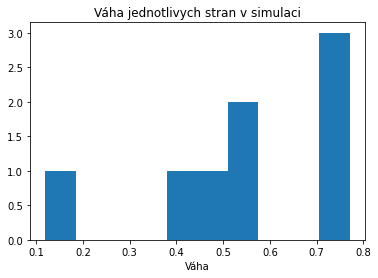

In [9]:
n = 8
a = stats.uniform.rvs(size = n)
plt.hist(a)
plt.xlabel("Váha")
plt.title("Váha jednotlivych stran v simulaci")
plt.show()

In [10]:
# simulate different methods
methods = ["dhondt", "hb", "droop", "imperiali"]
dhondt, hb, droop, imperiali = [Sim(n_seats = seats, n_parties=n, alpha = a) for m_ in methods] 
s = [dhondt, hb, droop, imperiali]
for keys, values in enumerate(s):
    values.sim_multi(N = 1000, threshold = 0.05, method=methods[keys])

In [11]:
# some utils to extract info about difference
d_dhondt, d_hb, d_droop, d_imperiali = [utils.extract_diff(s_.sim["seats"], s_.sim["votes"]) for s_ in s]
d = [d_dhondt, d_hb, d_droop, d_imperiali]

Dva grafy dole ukazují density rozdílu obou metod. Rozdložení rozdílů u D'Hondtovy metody je zhruba 2x tak velké jako u Hagenbach-Bischoffovy metody. Stejně tak je i MAE skoro 2x veliká. Metoda Droop se chová podobně jako Hagenbach-Bischoff. Iperiali je někde mezi.

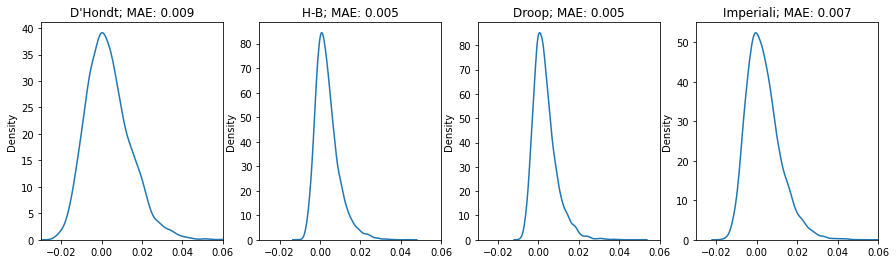

In [12]:
methods = ["D'Hondt", "H-B", "Droop", "Imperiali"]
fig, ax = plt.subplots(1, 4, figsize = (15,4))
plt.setp(ax, xlim=(-0.03, 0.06))

#calc MAE
mae = [np.mean(np.abs(x["d"])).round(3) for x in d]

for i in range(len(methods)):
    sns.kdeplot(d[i]["d"], ax = ax[i])
    ax[i].set_title(f"{methods[i]}; MAE: {mae[i]}")
        
plt.show()

Rozdíly mezi podílem mandátů a podílem hlasů jsou závislé na počtu hlasů. Grafy dole ukazují tento vztah. U D'Hondtovy metody mají v průměru méně mandátů než hlasů strany, které získají více než 12% hlasů (v celé ČR). U Hagenbach-Bischoffovy metody jsou znevýhodňovány (v průměru) strany, které získají 9% a méně hlasů (v celé ČR). U D'Hondtovy metody očekáváme, že (v průměru) při nárůstu hlasů o 10 procentních bodů, se zvýší rozdíl mandátů o 1.5 procentního bodu. U Hagenbach-Bischoffovy metody pak očekáváme nárůst rozdílu mandátů a hlasů o 0.7 procentního bodu. U metody Dropp je pak tento očekávaný nárůst podobný, tedy 0.7. Metoda Imperiali je spíše blíže současné metodě s očekávaným nárůstem o 1.2 procentních bodů. Je tedy důležité zdůraznit, že všechny metody vedou k disprorcionálnímu zvýhodňování vítězů a to za všech simulovaných skutečností. U Hagenbach-Bischoffovy metody je tato disprorcionalita zhruba poloviční.

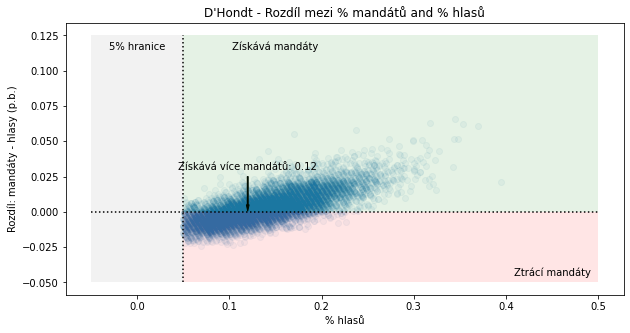

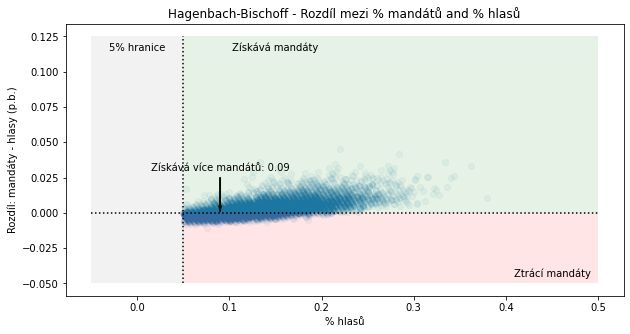

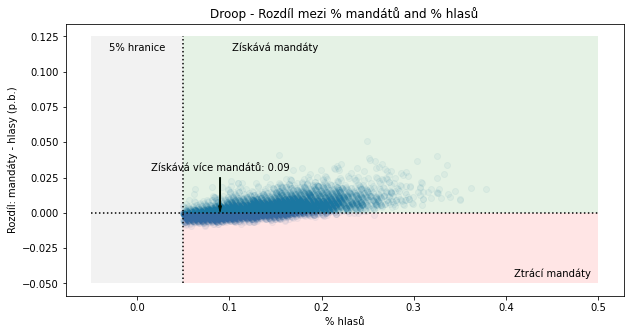

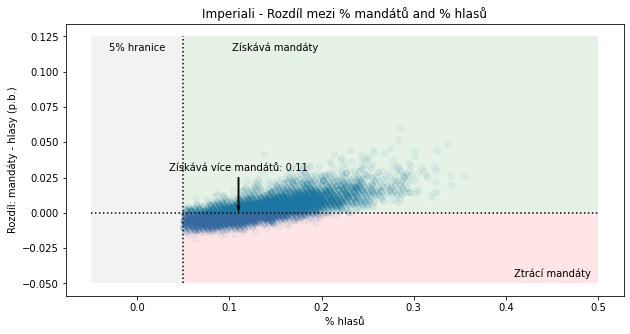

In [13]:
#dhondt
utils.plot_diff(d=d_dhondt["d"],v=d_dhondt["v"], d0=d_dhondt["d0"], tItle = "D'Hondt - Rozdíl mezi % mandátů and % hlasů")
#hb
utils.plot_diff(d=d_hb["d"],v=d_hb["v"], d0=d_hb["d0"], tItle = "Hagenbach-Bischoff - Rozdíl mezi % mandátů and % hlasů")
#droop
utils.plot_diff(d=d_droop["d"],v=d_droop["v"], d0=d_droop["d0"], tItle = "Droop - Rozdíl mezi % mandátů and % hlasů")
#imperiali
utils.plot_diff(d=d_imperiali["d"],v=d_imperiali["v"], d0=d_imperiali["d0"], tItle = "Imperiali - Rozdíl mezi % mandátů and % hlasů")

Dalším důležitým faktorem je ale také rozptyl výsledků, které je u D'Hondtovy metody opět zhruba 2x větší. To tedy znamená, že rozložení hlasů více záleží na tom, v kterých krajích mají dané strany podporu (větší nebo menší kraje). Například i strany, které získají přes 12% mohou mít výrazně více (nebo méně) mandátů, než co odpovídá jejím hlasům (od -2 do 2 procentních bodů). I přes tento větší rozptyl však platí, že strany které přesáhnou 20% mají u D'Hondtovy metody takřka zaručený disproporcionálně větší počet mandátů (díky většímu zvýhodnění větších stran). Všichni vítězové voleb od roku 2006 přesáhli hranici 20% a většinou atakovali hranici 30%. V takovém případě očekáváme, že získají až o 5 procentních bodů více mandátů, než jim přísluší (při scénáři naší simulace). I u Hagenbach-Bischoffovy metody by byla většina vítězů voleb zvýhodněna, zřídkakdy však o více než 3 procentní body. Stále platí, že metoda Dropp je podobná metodě Hagenbach-Bischoff a metoda Imperiali je někde mezi oběma póly, spíše blíže současné metodě.

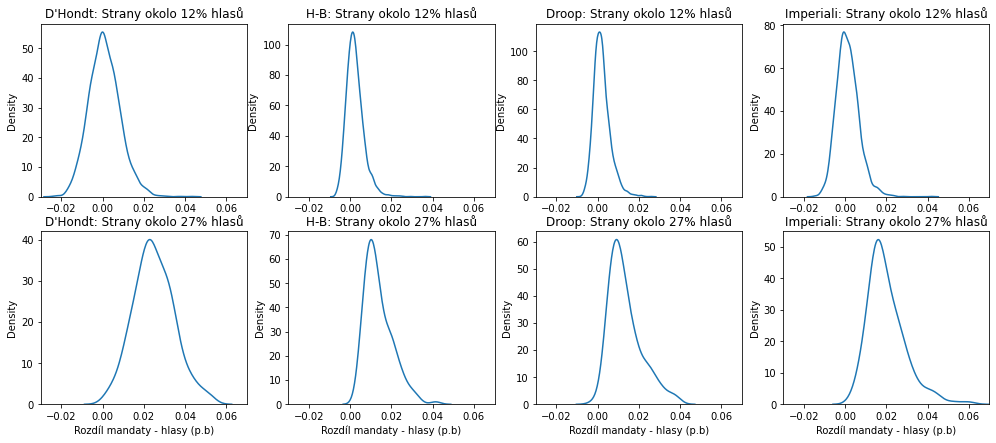

In [15]:
fig, ax = plt.subplots(2,4, figsize = (17,7))
plt.setp(ax, xlim = (-0.03, 0.07))
for i in range(2):
    for j in range(len(methods)):
        if i==0:
            sns.kdeplot(d[j]["d"][(d[j]["v"] > 0.1) & (d[j]["v"] < 0.15)], ax = ax[i,j])
            ax[i,j].set_title(f"{methods[j]}: Strany okolo 12% hlasů")
        if i==1:
            sns.kdeplot(d[j]["d"][(d[j]["v"] > 0.25) & (d[j]["v"] < 0.3)], ax = ax[i,j])
            ax[i,j].set_title(f"{methods[j]}: Strany okolo 27% hlasů")
            ax[i,j].set_xlabel("Rozdíl mandaty - hlasy (p.b)")

plt.show()